In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import rasterio as rio
from scipy.interpolate import griddata
import pyproj
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import itertools as it

path_root = os.path.join(os.environ['E3SM_ROOT'], 'inputdata', 'lnd', 'clm2', 
                         'surfdata_map')
file_orig = os.path.join(path_root, 'surfdata_conus_erw_off_simyr1850_c211019.nc')
file_temp = os.path.join(path_root, 'surfdata_conus_erw.temp.nc')
file_dest = os.path.join(path_root, 'surfdata_conus_erw_on_simyr1850_c211019.nc_not_masked')
file_dest2 = os.path.join(path_root, 'surfdata_conus_erw_on_simyr1850_c211019.nc')

# copy from the non-ERW file
os.system(f"cp {file_orig} {file_temp}")

0

In [2]:
# Read soil grids pH and CEC_TOT
path_soilgrids = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data')

soilgrids_map = {}
for j, (col, newname) in enumerate(zip(
    ['cec_mean.tif', 'phh2o_mean.tif'], 
    ['CEC_TOT', 'SOIL_PH']
)):
    h = rio.open(os.path.join(path_soilgrids, col))

    # google earth engine exported file already in EPSG 4326
    left, bottom, right, top = h.bounds
    crs = h.crs
    rows, cols = np.indices(h.shape)
    src_x, src_y = rio.transform.xy(h.transform, rows, cols)
    lons = np.array(src_x)
    lats = np.array(src_y)

    # conduct reprojection
    lats_target = np.arange(23.25, 54.26, 0.5)
    lons_target = np.arange(234.75, 293.26, 0.5) - 360.
    lons_target, lats_target = np.meshgrid(lons_target, lats_target)
    src_coords = np.array([lons.flatten(), lats.flatten()]).T

    # loop through the layers
    soilgrids_map[newname] = []
    for i in range(1, h.count+1):
        # read data
        data = h.read(i, masked = False)

        # scale CEC from mmol/kg to mmol 100g-1 dry soil
        # scale pHx10 to pH
        data = data / 10.

        # remote problematic values
        if newname == 'CEC_TOT':
            data = np.where(data > 0, data, np.nan)
        elif newname == 'SOIL_PH':
            data = np.where(data > 1, data, np.nan)

        src_data_flat = data.flatten()
        data_reproj = griddata(src_coords, src_data_flat, (lons_target, lats_target),
                               method='linear')

        # hand-fill three single-pixel inside holes
        data_reproj[20, 19] = np.nanmean(data_reproj[19:22, 18:21])
        data_reproj[36, 25] = np.nanmean(data_reproj[35:38, 24:27])
        data_reproj[46, 63] = np.nanmean(data_reproj[45:48, 62:65])

        # save transformed data
        soilgrids_map[newname].append(data_reproj)

    h.close()

In [3]:
# Stack and convert to xarray format
soilgrids_top = np.array([0, 5, 15, 30, 60, 100]) # cm
soilgrids_bot = np.array([5, 15, 30, 60, 100, 200])
soilgrids_node = 0.5 * (soilgrids_top + soilgrids_bot) / 100
elm_nodes = np.array([0.0071, 0.0279, 0.0623, 0.1189, 0.2122, 0.3661, 0.6198, 1.0380, 1.7276, 2.8646])

soilgrids_data = {}
for col in soilgrids_map.keys():
    # Layer mapping: weighted average
    temp = [soilgrids_map[col][0]]
    for node in elm_nodes[1:-2]:
        prev = np.where(soilgrids_node < node)[0][-1]
        next = np.where(soilgrids_node > node)[0][0]
        next_weight = (node - soilgrids_node[prev])
        prev_weight = (soilgrids_node[next] - node)

        # print(node, prev, next, soilgrids_node[prev], soilgrids_node[next])

        temp.append( (soilgrids_map[col][prev]*prev_weight + soilgrids_map[col][next]*next_weight) / (prev_weight + next_weight) )
    temp.extend([soilgrids_map[col][-1], soilgrids_map[col][-1]])

    data = np.stack(temp, axis = 2)
    data = np.moveaxis(data, source=2, destination=0)
    soilgrids_data[col] = xr.DataArray(data, dims = ['nlevsoi','lsmlat','lsmlon']) # no coords in surfdata file
soilgrids_data = xr.Dataset(soilgrids_data)

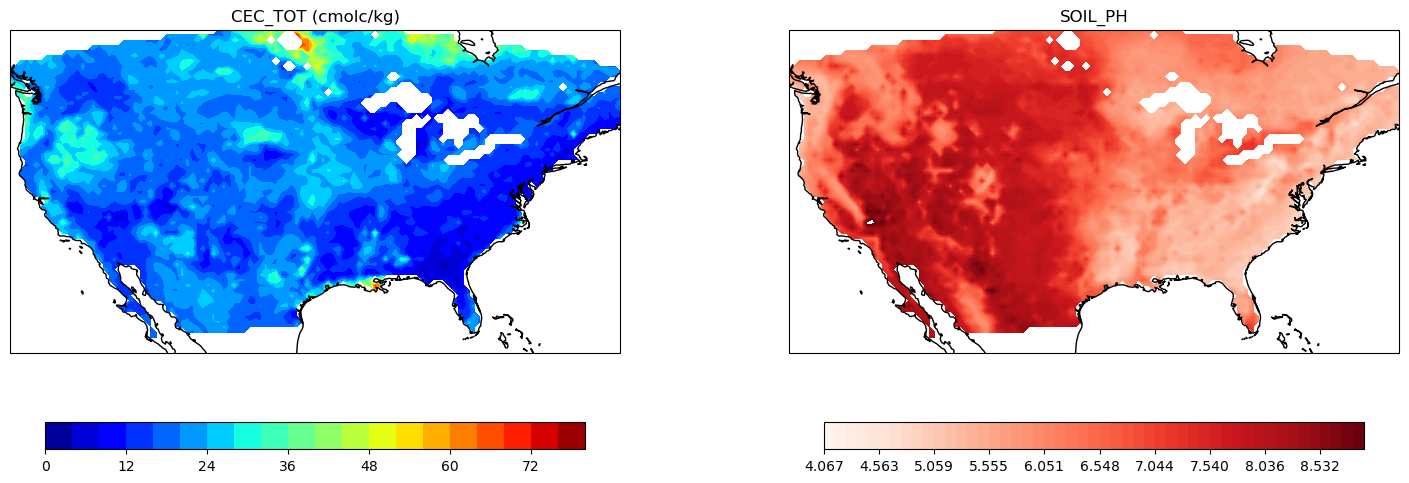

In [6]:
# sanity check
fig, axes = plt.subplots(1, 2, figsize = (20, 6), subplot_kw = {'projection': ccrs.PlateCarree()})
fig.subplots_adjust(wspace = 0.01)
for i, var in enumerate(soilgrids_data.data_vars):
    ax = axes.flat[i]
    ax.coastlines()
    if i == 1:
        # levels = np.linspace(0, 10, 21)
        levels = np.linspace(4.067, 8.929)
        cmap = 'Reds'
    else:
        levels = np.linspace(0, 80, 21)
        cmap = 'jet'
    cf = ax.contourf(lons_target[0,:], lats_target[:,0], soilgrids_data[var][0, :, :], 
                     cmap = cmap, levels = levels)
    plt.colorbar(cf, ax = ax, orientation = 'horizontal', shrink = 0.7)
    if i == 0:
        ax.set_title(var + ' (cmolc/kg)')
    else:
        ax.set_title(var)

In [7]:
# Read NCSS maps and convert to surfdata's xarray format
path_cec = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results')

hr = xr.open_dataset(os.path.join(path_cec, 'RF_NCSS_filled_interp.nc'))

CEC_data = {}
for j, (col, newname) in enumerate(zip(
    ['beta_Ca', 'beta_Mg', 'beta_Na', 'beta_K', 'beta_Al', 'beta_H'],
    ['CEC_EFF_1', 'CEC_EFF_2', 'CEC_EFF_3', 'CEC_EFF_4', 'CEC_EFF_5', 'CEC_ACID'],
)):
    CEC_data[newname] = xr.DataArray(
        soilgrids_data['CEC_TOT'].values * hr[col].values, 
        dims = ['nlevsoi','lsmlat','lsmlon'])

hr.close()

CEC_data = xr.Dataset(CEC_data)

In [20]:
# Check no values < 0 exists
for i,j in it.product(range(10), ['CEC_EFF_1', 'CEC_EFF_2', 'CEC_EFF_3', 'CEC_EFF_4', 
                                  'CEC_EFF_5', 'CEC_ACID']):
    print(np.where(CEC_data['CEC_EFF_1'][i, :, :] < 0.05))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int

In [21]:
# percentage kaolinite and calcite in soil
# The layers are: elm_bot = np.array([0.0906,  0.8289, 1.3828])
path_mineral = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results')

mineral_data = {}
for j, (col,newname) in enumerate(zip(['Kaolinit', 'Calcite'],['KAOLINITE','CALCITE'])):
    hr = xr.open_dataset(os.path.join(path_mineral, f'RF_{col}_filled_interp.nc'))
    mineral_data[f'PCT_{newname}'] = xr.DataArray(hr[f'PCT_{col}'].values, 
                                                  dims = ['nlevsoi','lsmlat','lsmlon'])
    hr.close()

mineral_data = xr.Dataset(mineral_data)

In [22]:
# put into the NetCDF
encoding = {}
for col in soilgrids_map.keys():
    encoding[col] = {'dtype': np.float32, '_FillValue': 1e20}
for col in CEC_data.keys():
    encoding[col] = {'dtype': np.float32, '_FillValue': 1e20}
for col in mineral_data.keys():
    encoding[col] = {'dtype': np.float32, '_FillValue': 1e20}

soilgrids_data['SOIL_PH'].attrs = {'long_name': 'soil pH', 'units': ''}
soilgrids_data['CEC_TOT'].attrs = {'long_name': 'total cation exchange capacity', 
                                   'units': 'meq 100g-1 dry soil'}
CEC_data['CEC_ACID'].attrs = {'long_name': 'acid cation exchange capacity', 
                              'units': 'meq 100g-1 dry soil'}
for i in range(1,5):
    CEC_data[f'CEC_EFF_{i}'].attrs = {'long_name': 'individual cation exchange capacity', 
                                      'units': 'meq 100g-1 dry soil'}
mineral_data['PCT_KAOLINITE'].attrs = {'long_name': 'percentage naturally occuring kaolinite in soil mineral', 'units': 'g 100 g-1 soil'}
mineral_data['PCT_CALCITE'].attrs = {'long_name': 'percentage naturally occuring CaCO3 in soil mineral', 'units': 'g 100 g-1 soil'}

hr = xr.open_dataset(file_temp)
hr.update(CEC_data)
hr.update(soilgrids_data)
hr.update(mineral_data)
hr.to_netcdf(file_dest, encoding = encoding, format = 'NETCDF4_CLASSIC')
hr.close()

os.system(f'rm {file_temp}')

0

In [23]:
# Set mask = 0 and frac = 0 for all the grids without data
hr_domain = xr.open_dataset(os.path.join(os.environ['E3SM_ROOT'], 'inputdata', 'share', 'domains', 
                            'domain.clm', 'domain.lnd.conus_erw_jra.240712.nc_not_masked'))

new_mask = np.full(hr_domain['mask'].shape, 1)

# The CEC and soil pH values should always be > 0
var_list = list(CEC_data.keys()) + list(soilgrids_data.keys())
hr = xr.open_dataset(file_dest)
for var in var_list:
    new_mask = new_mask & np.all(hr[var].values > 0, axis = 0)
# The mineral values should be >= 0
for var in mineral_data.keys():
    new_mask = new_mask & np.all(hr[var].values >= 0, axis = 0)
hr.close()

# mask: integer [0,1] indicates where the land is
hr_domain['mask'] = hr_domain['mask'] & new_mask
hr_domain['frac'] = hr_domain['frac'].where(hr_domain['mask'], 0.)

# change the associated LANDFRAC_PFT in the surfdata set
hr = xr.open_dataset(file_dest)
hr['LANDFRAC_PFT'][:, :] = hr_domain['frac'].values
hr.to_netcdf(file_dest2, encoding = encoding, format = 'NETCDF4_CLASSIC')
hr.close()

encoding2 = {}
for var in hr_domain.variables:
    encoding2[var] = {'_FillValue': None}

hr_domain.to_netcdf(os.path.join(os.environ['E3SM_ROOT'], 'inputdata', 'share', 'domains', 
                                 'domain.clm', 'domain.lnd.conus_erw_jra.240712.nc'), 
                    format = 'NETCDF4_CLASSIC', encoding = encoding2)

hr_domain.close()

Final quality check - there should not be any problematic data values inside mask

In [24]:
hr_domain = xr.open_dataset(
    os.path.join(os.environ['E3SM_ROOT'], 'inputdata', 'share', 'domains', 'domain.clm',
                 'domain.lnd.conus_erw_jra.240712.nc')
)
# integer [0,1] indicates where the land is; we only need this one
mask = hr_domain['mask'].values > 0
#hr_domain.close()

hr = xr.open_dataset(file_dest2)

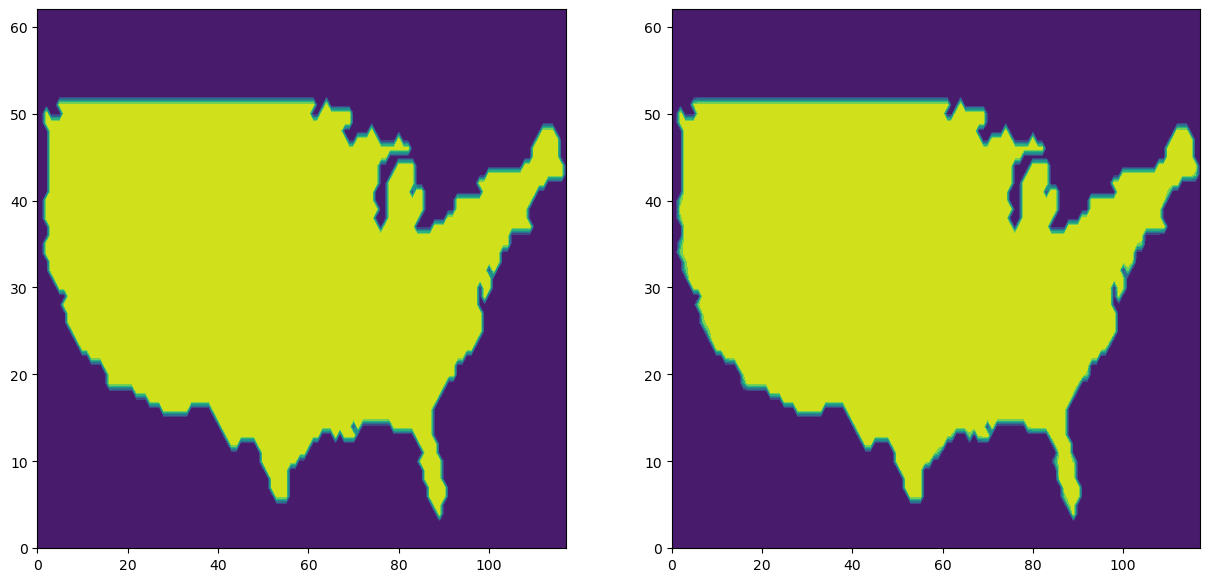

In [25]:
fig, axes = plt.subplots(1, 2, figsize = (15, 7))
ax = axes.flat[0]
ax.contourf(hr_domain['mask'])
ax = axes.flat[1]
ax.contourf(hr_domain['frac'])

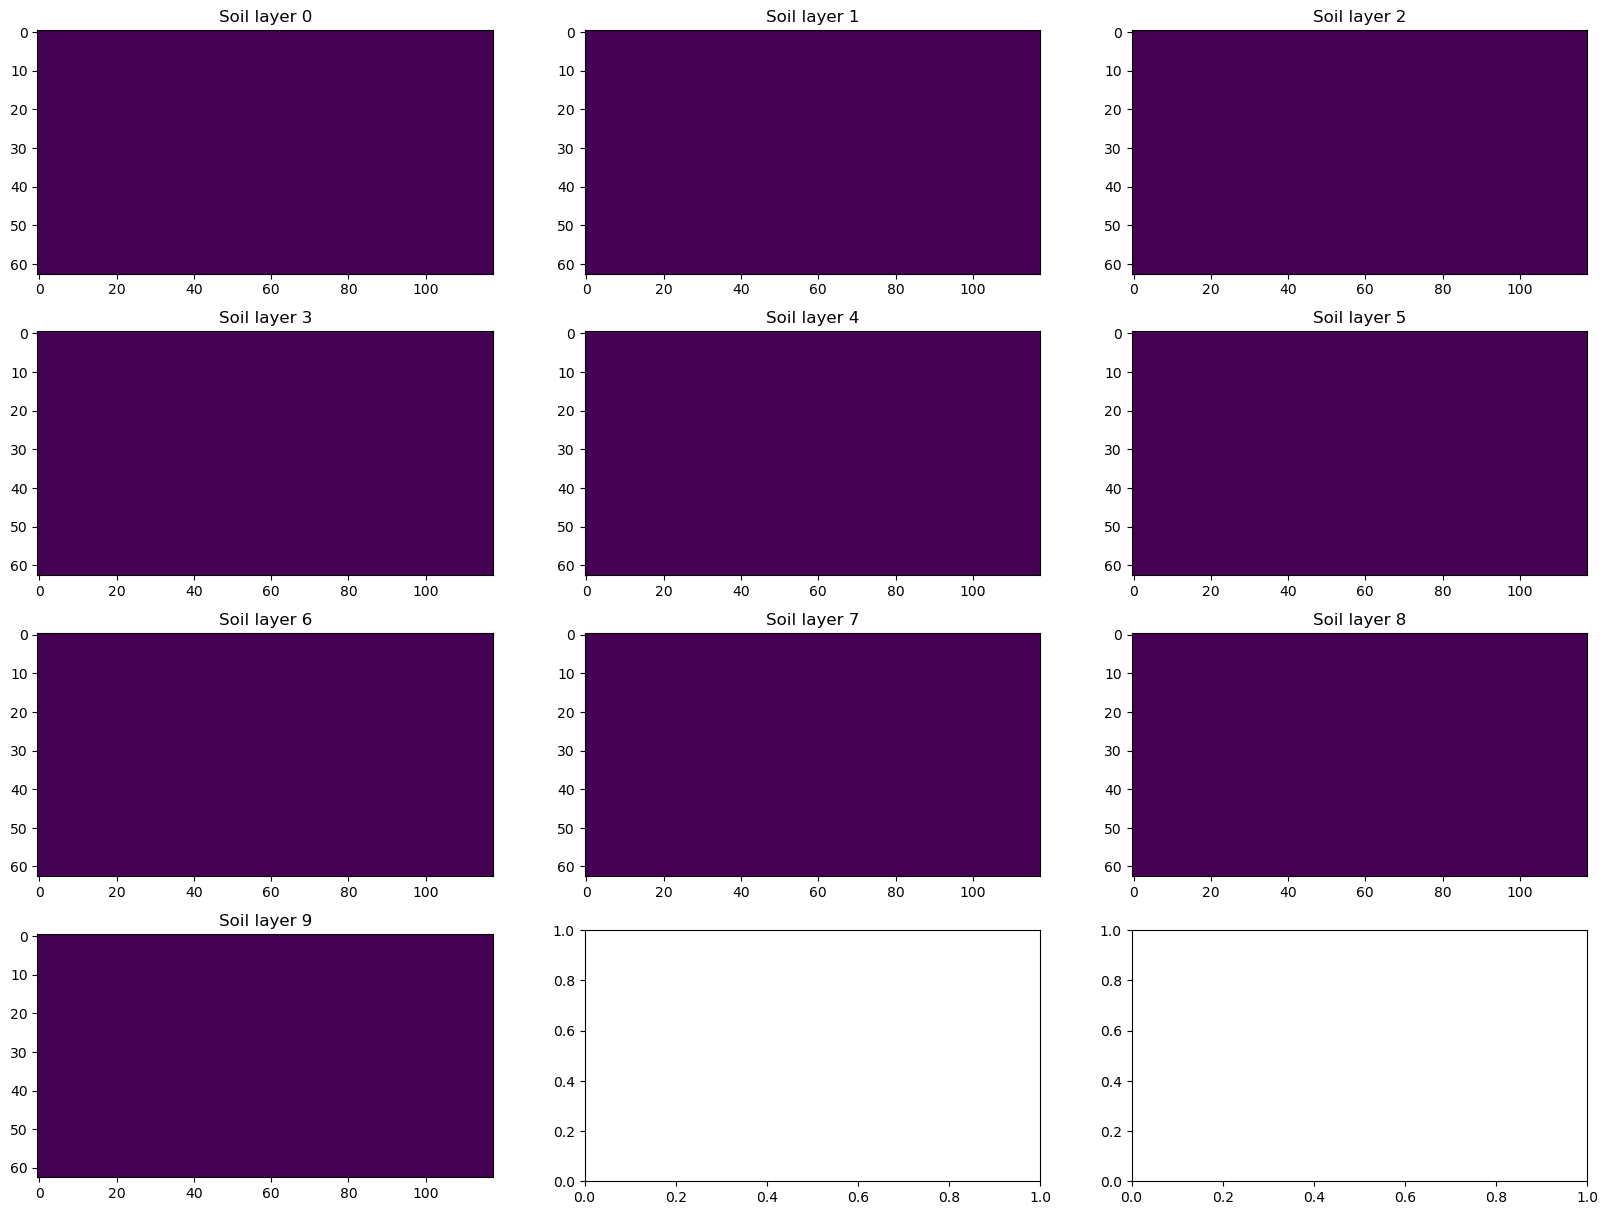

In [26]:
# (1) CEC_TOT
fig, axes = plt.subplots(4, 3, figsize = (20, 15))
for i in range(10):
    ax = axes.flat[i]
    mask_temp = mask[::-1, :] & ~(hr['CEC_TOT'][i,::-1,:].values > 0)
    ax.imshow(mask_temp)
    ax.set_title(f'Soil layer {i}')

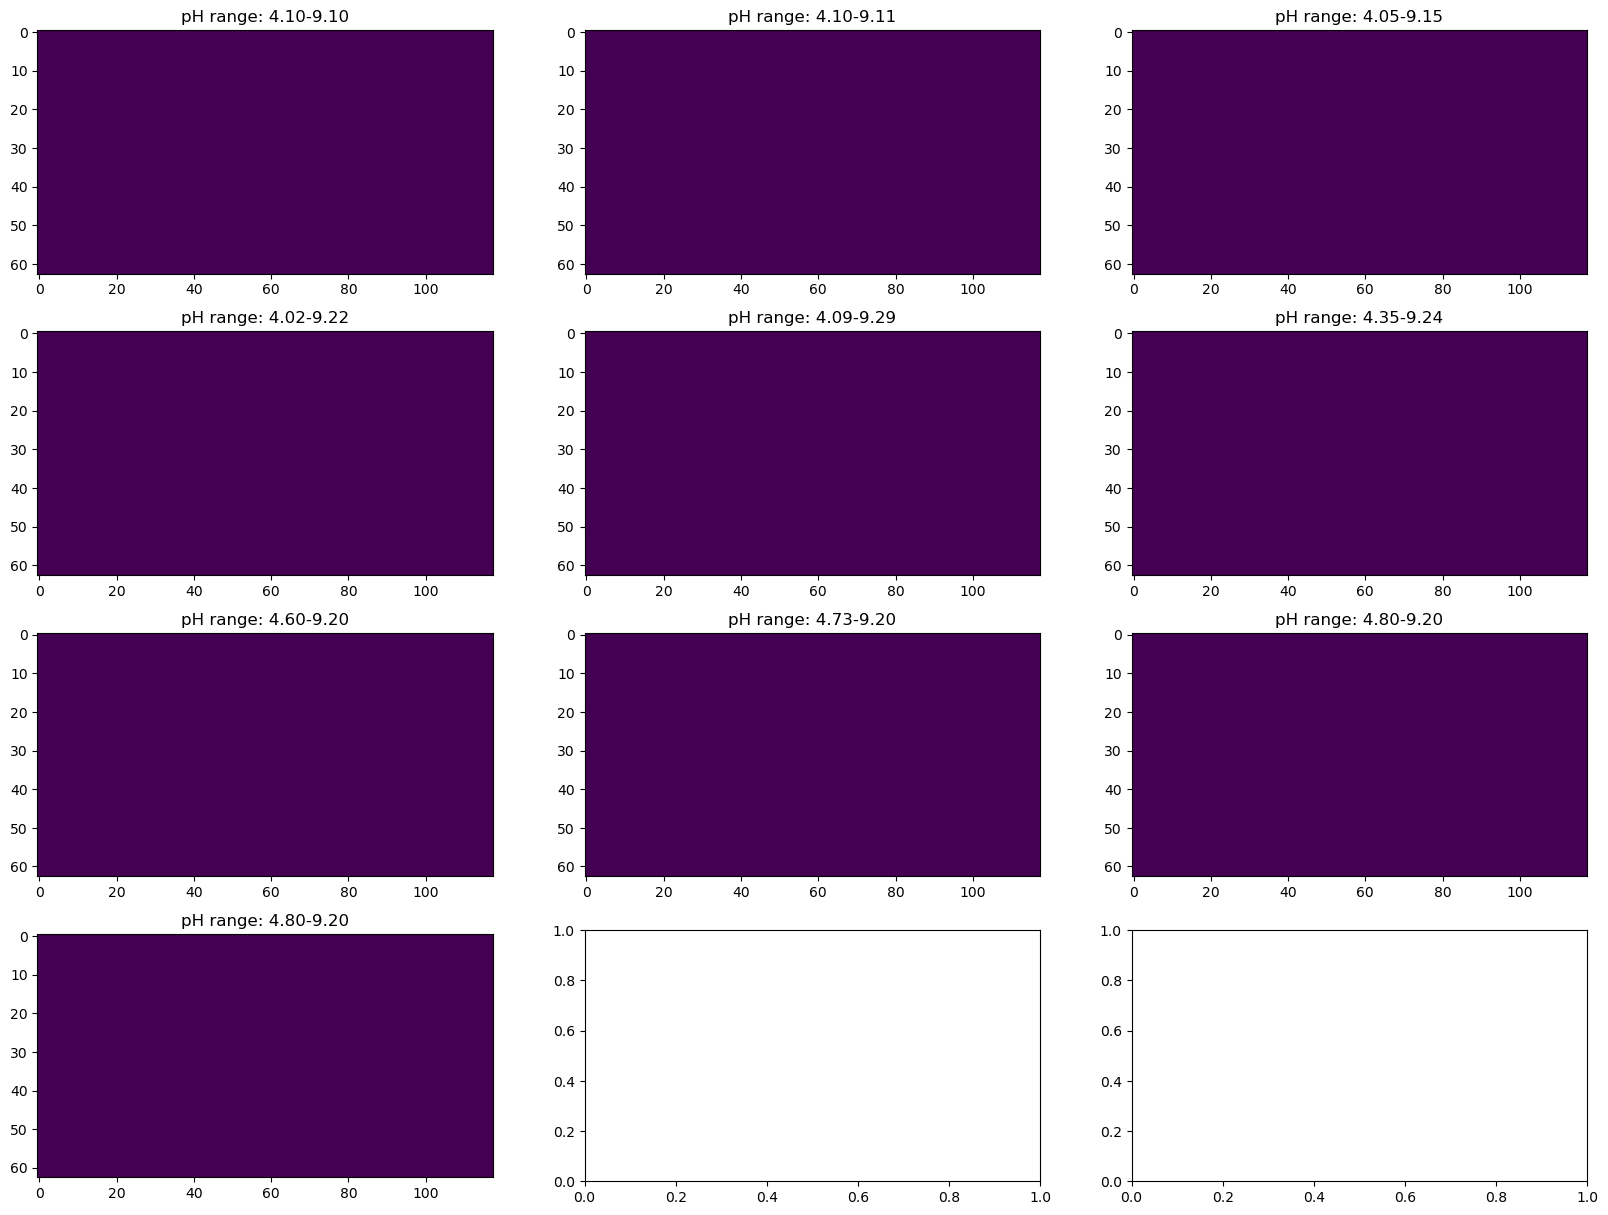

In [27]:
# (2) SOIL_PH
fig, axes = plt.subplots(4, 3, figsize = (20, 15))
for i in range(10):
    ax = axes.flat[i]
    data = hr['SOIL_PH'][i,::-1,:].values
    mask_temp = mask[::-1, :] & ~(data > 0)
    ax.imshow(mask_temp)
    ax.set_title(
        f'pH range: {np.nanmin(data):.2f}-{np.nanmax(data):.2f}'
    )

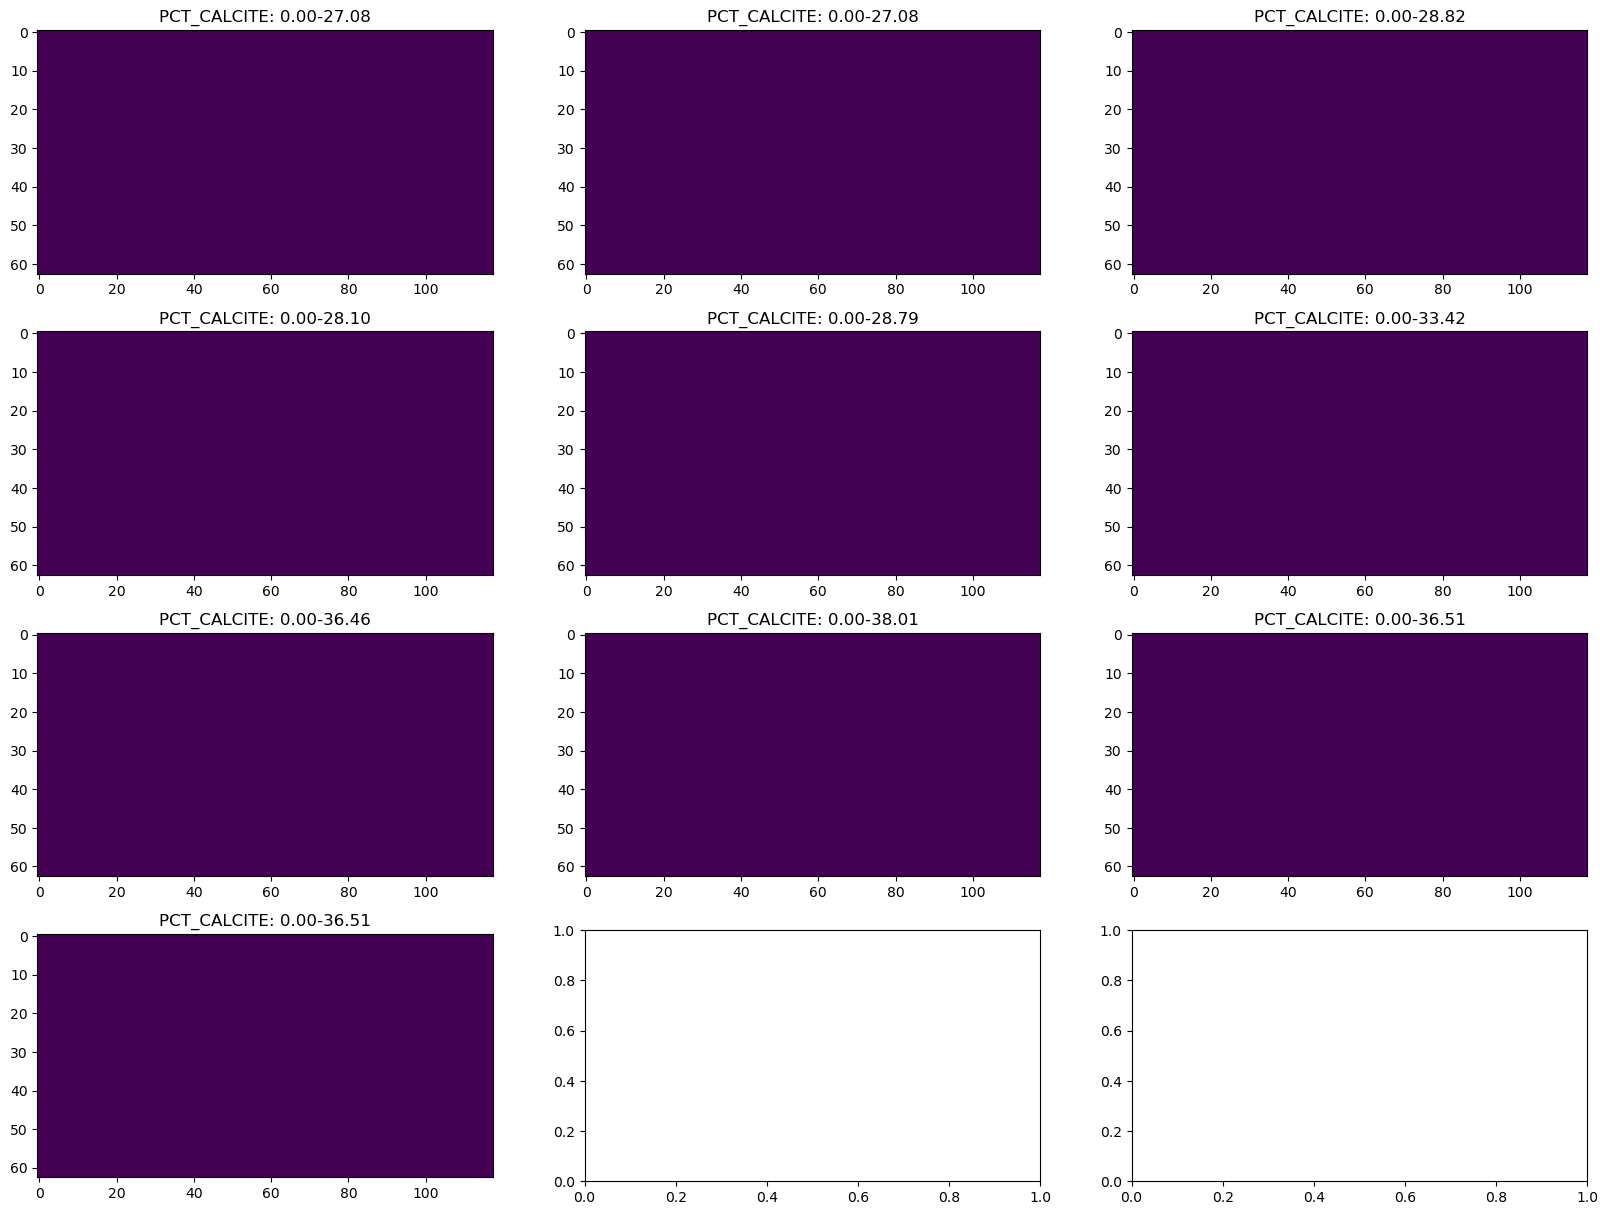

In [28]:
# (3) PCT_CALCITE
fig, axes = plt.subplots(4, 3, figsize = (20, 15))
for i in range(10):
    ax = axes.flat[i]
    data = hr['PCT_CALCITE'][i,::-1,:].values
    mask_temp = mask[::-1, :] & ~(data >= 0)
    ax.imshow(mask_temp)
    ax.set_title(
        f'PCT_CALCITE: {np.nanmin(data):.2f}-{np.nanmax(data):.2f}'
    )

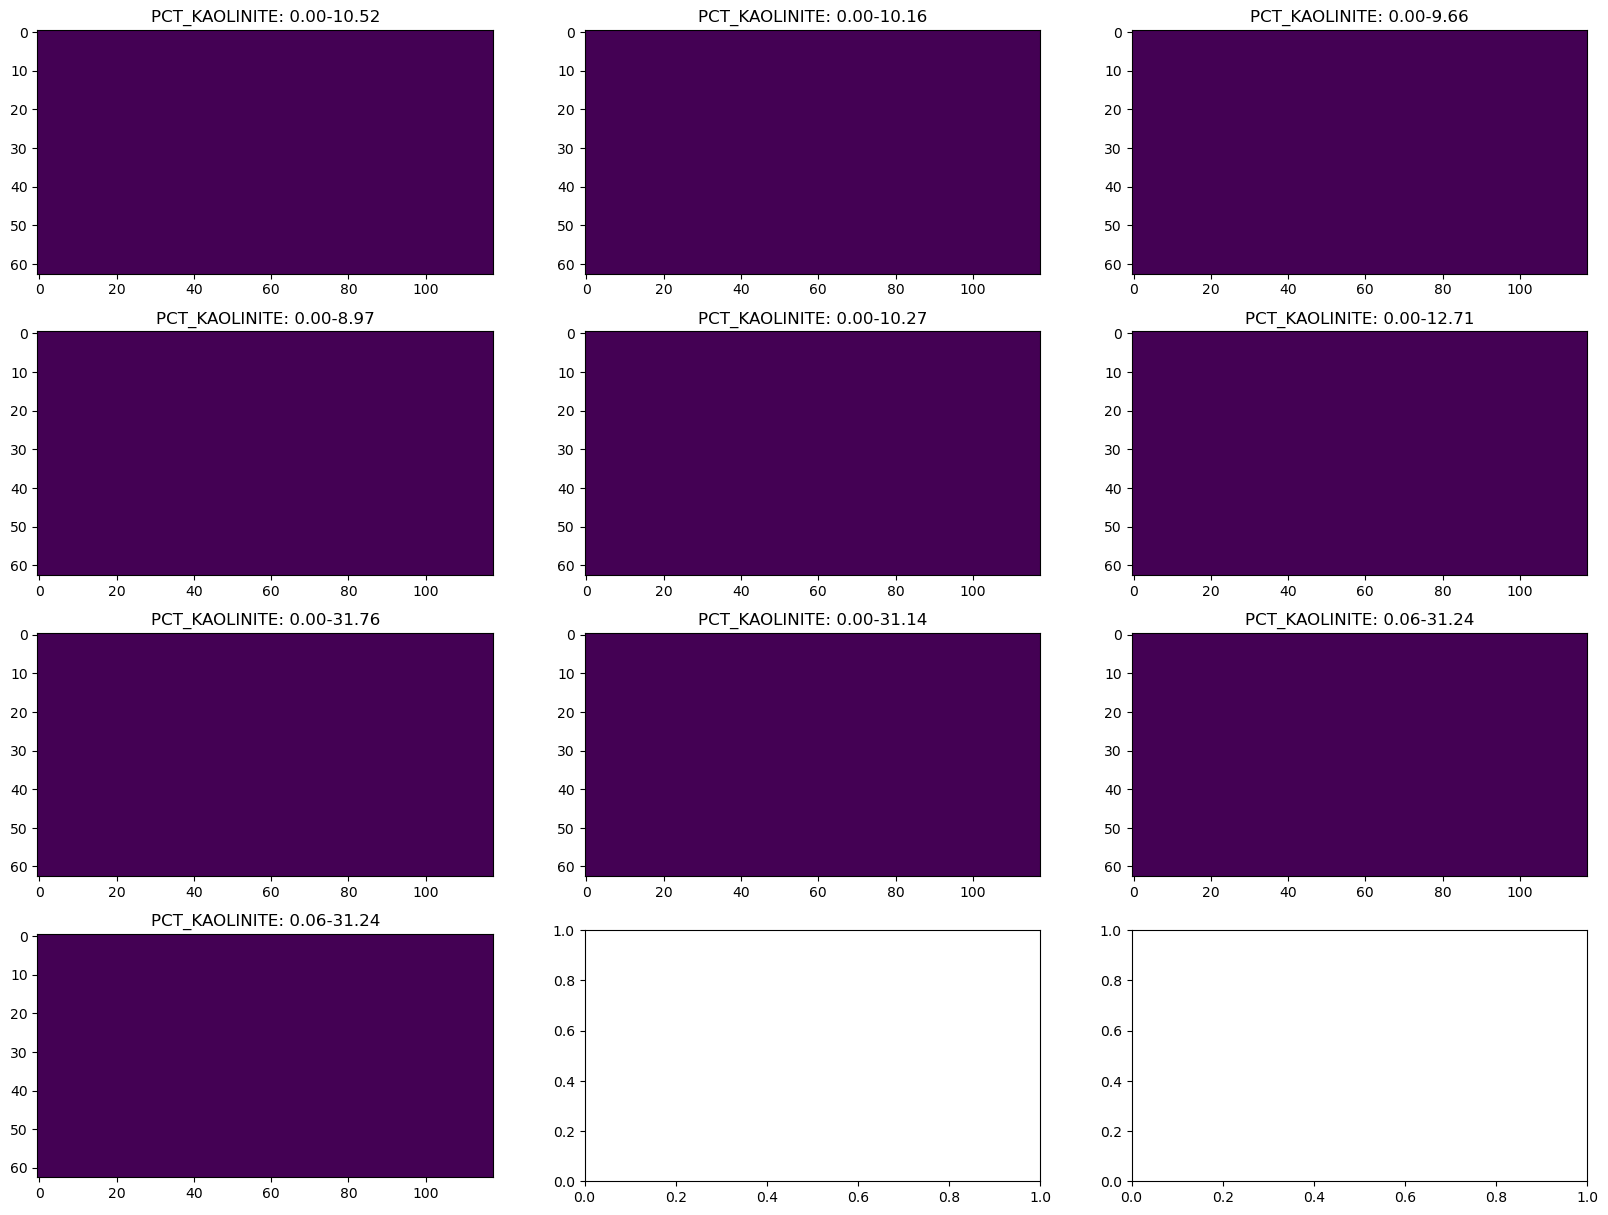

In [29]:
# (3) PCT_KAOLINIT
fig, axes = plt.subplots(4, 3, figsize = (20, 15))
for i in range(10):
    ax = axes.flat[i]
    data = hr['PCT_KAOLINITE'][i,::-1,:].values
    mask_temp = mask[::-1, :] & ~(data >= 0)
    ax.imshow(mask_temp)
    ax.set_title(
        f'PCT_KAOLINITE: {np.nanmin(data):.2f}-{np.nanmax(data):.2f}'
    )

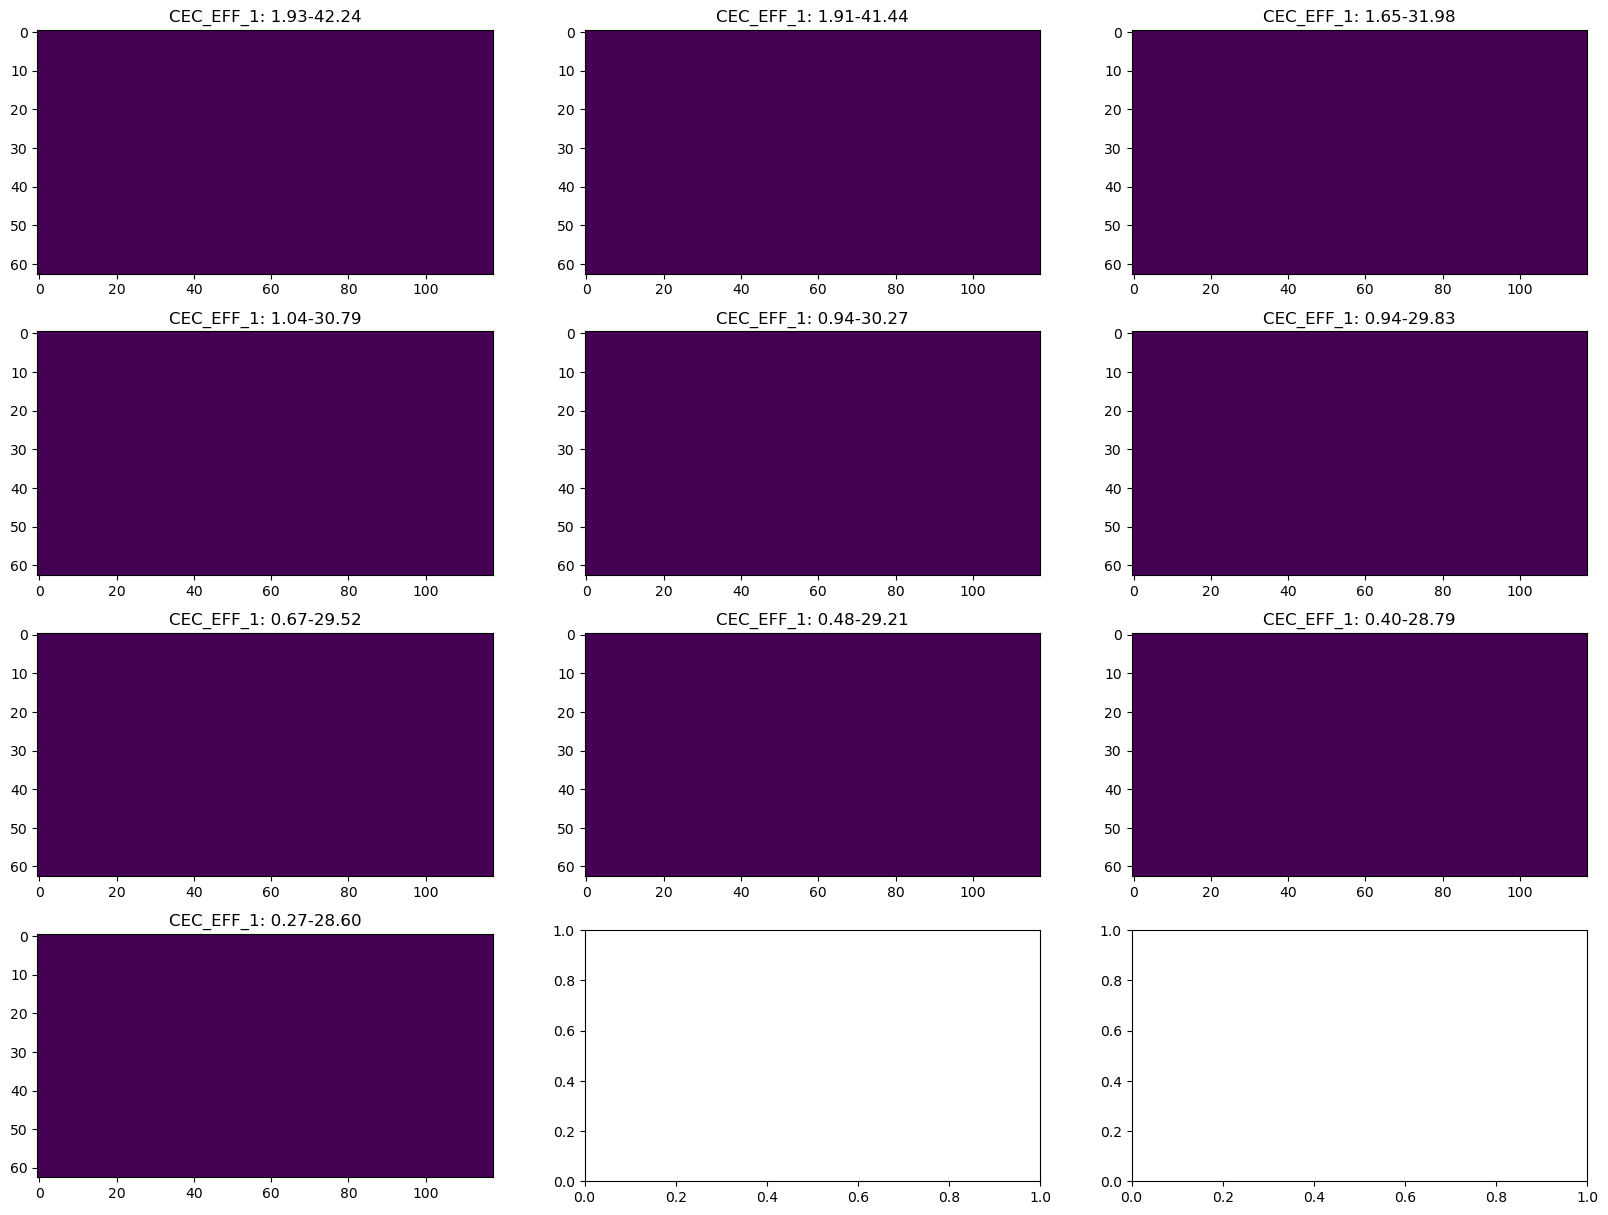

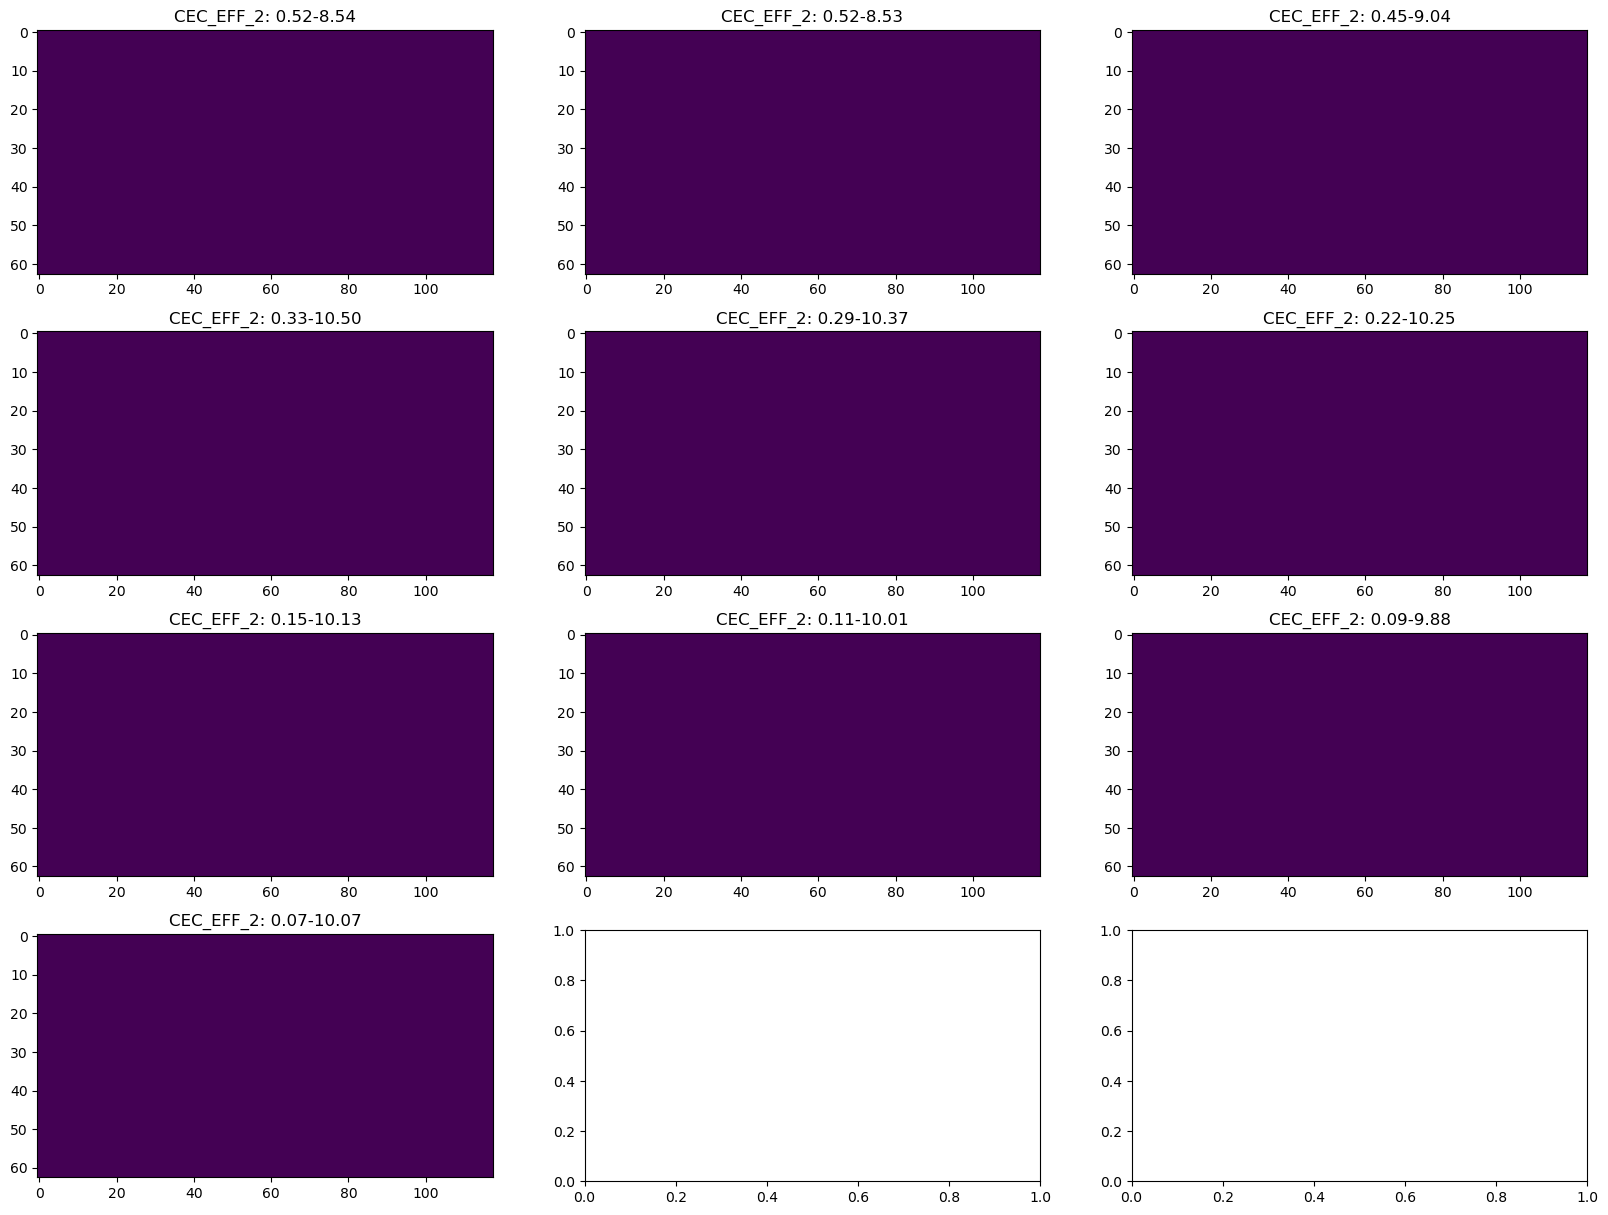

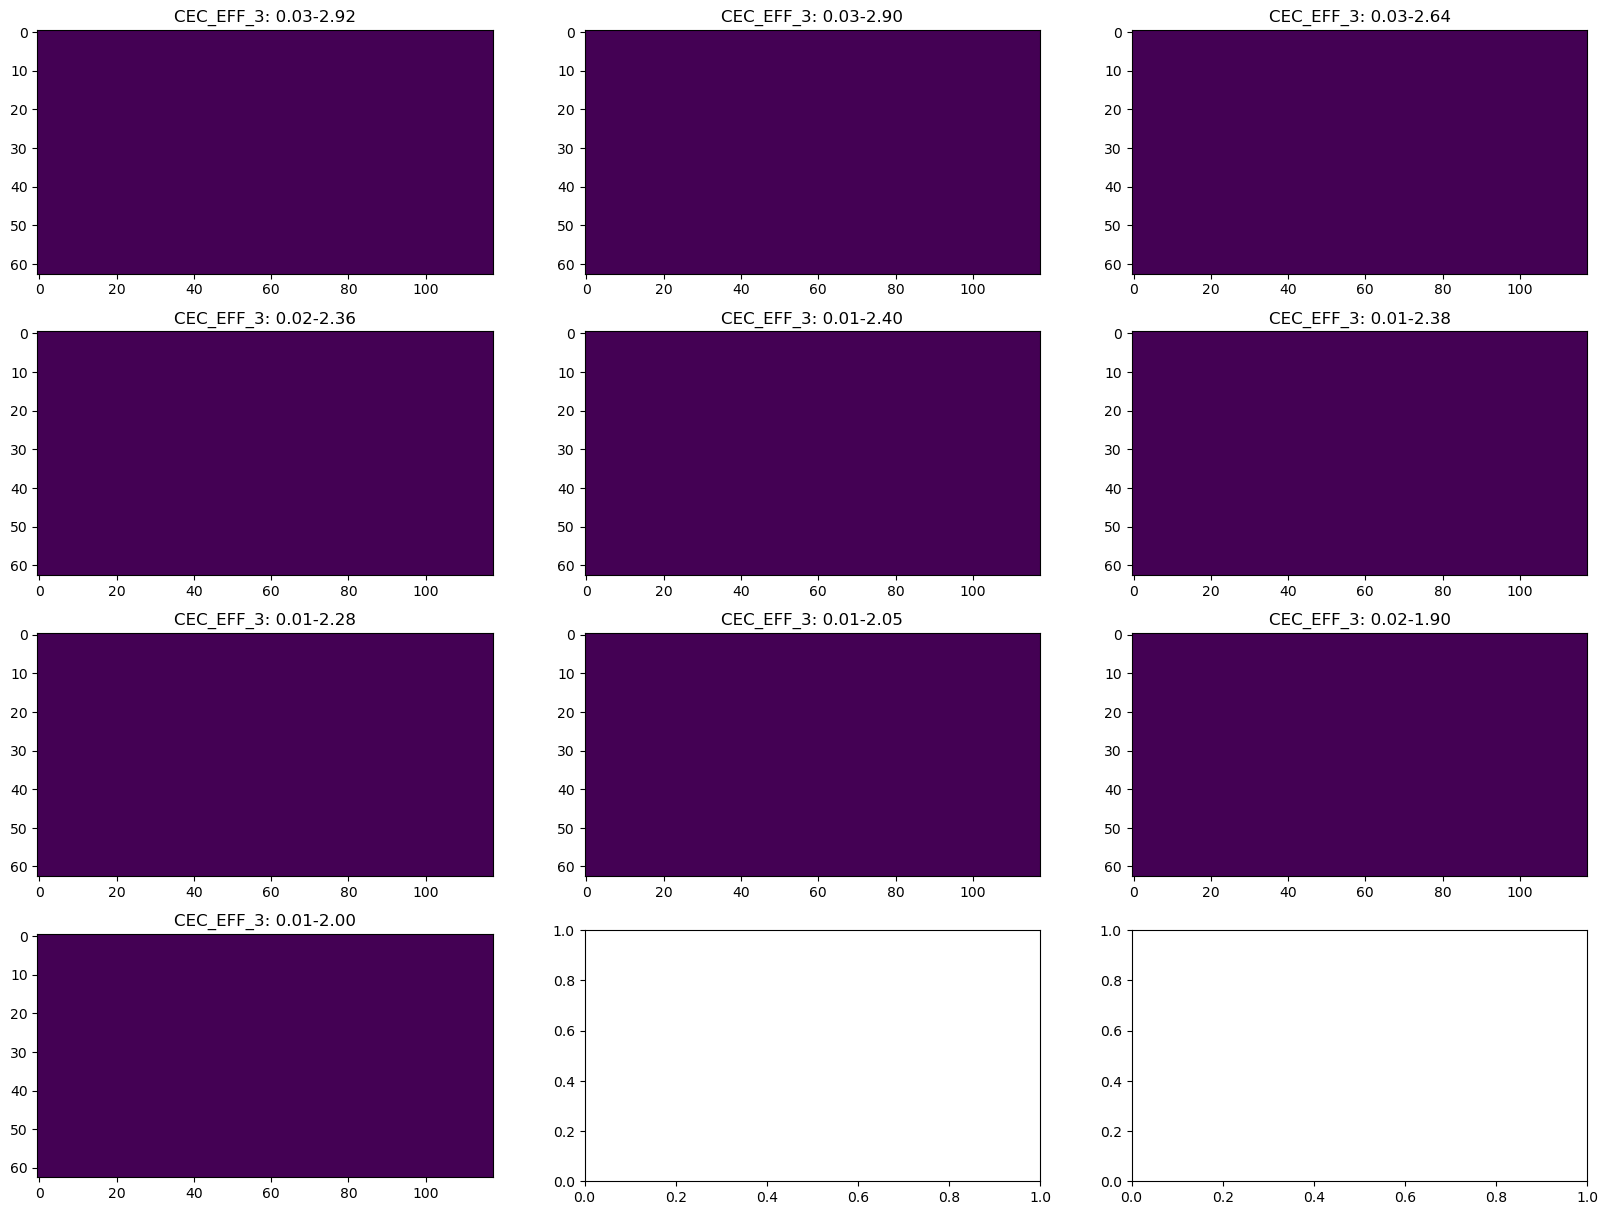

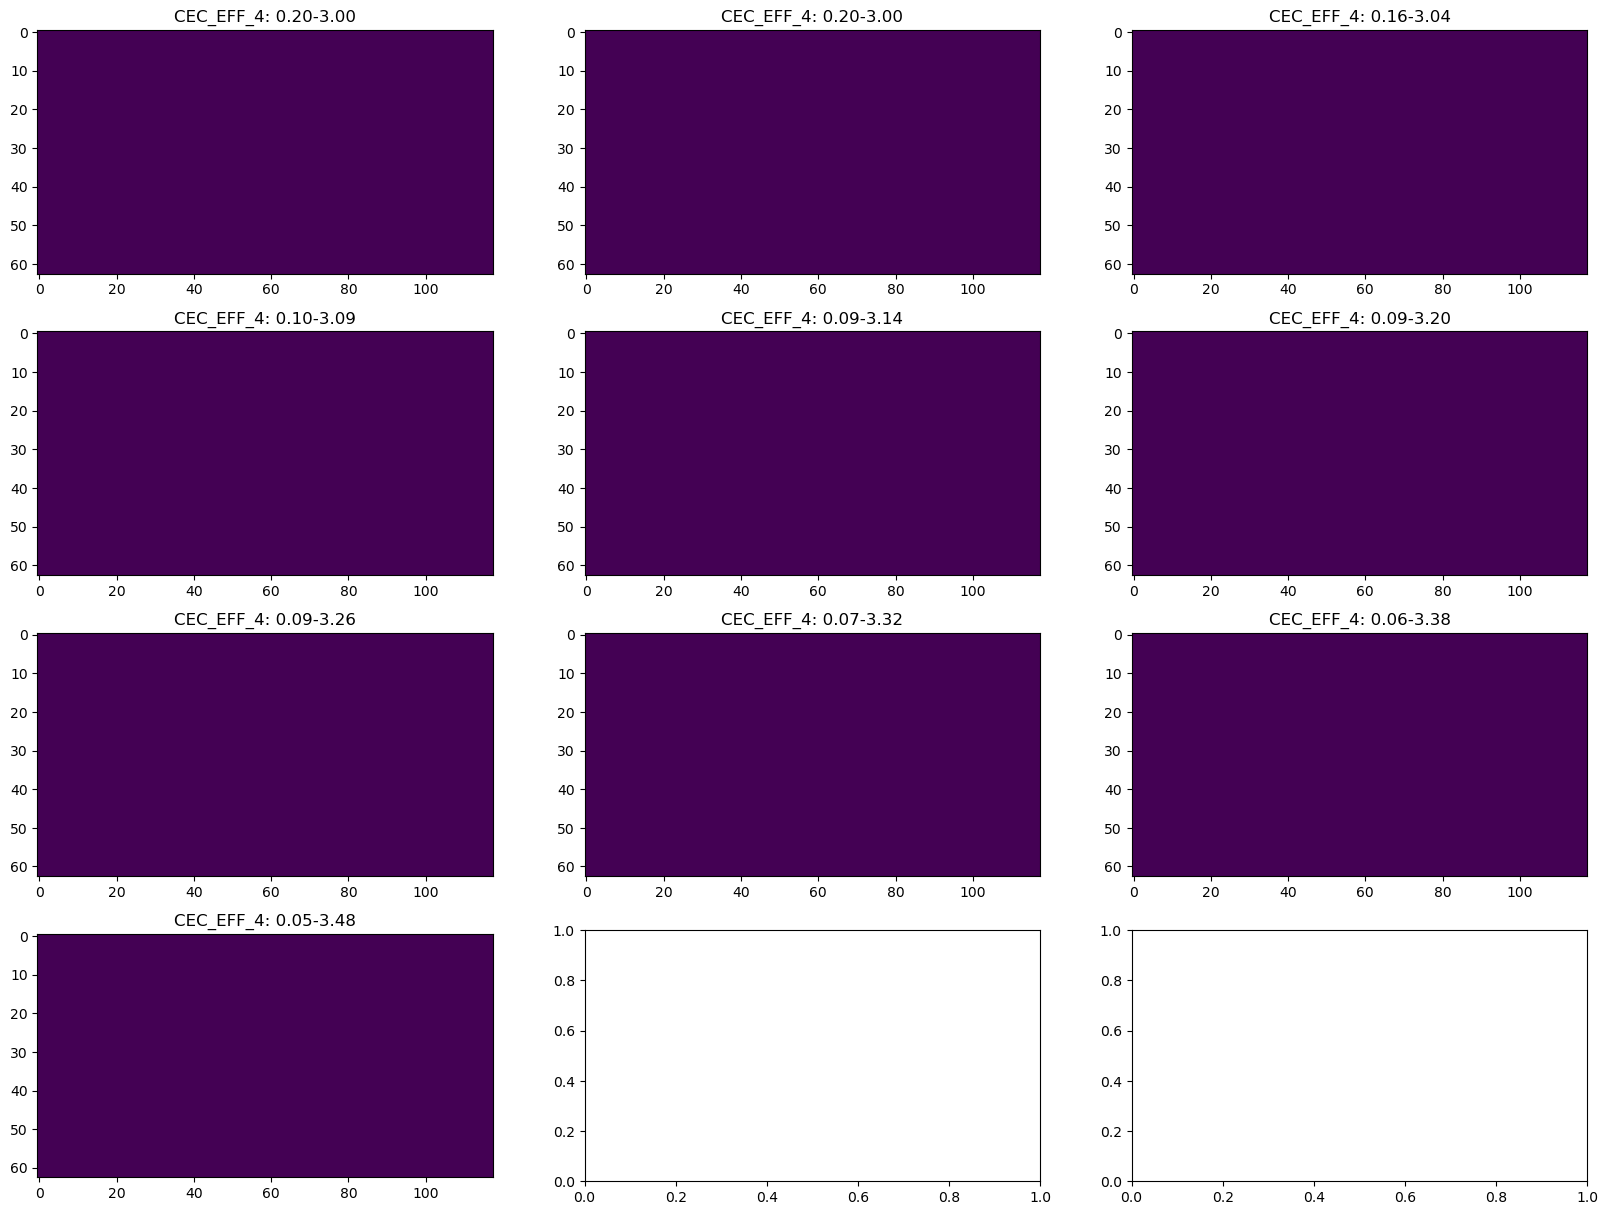

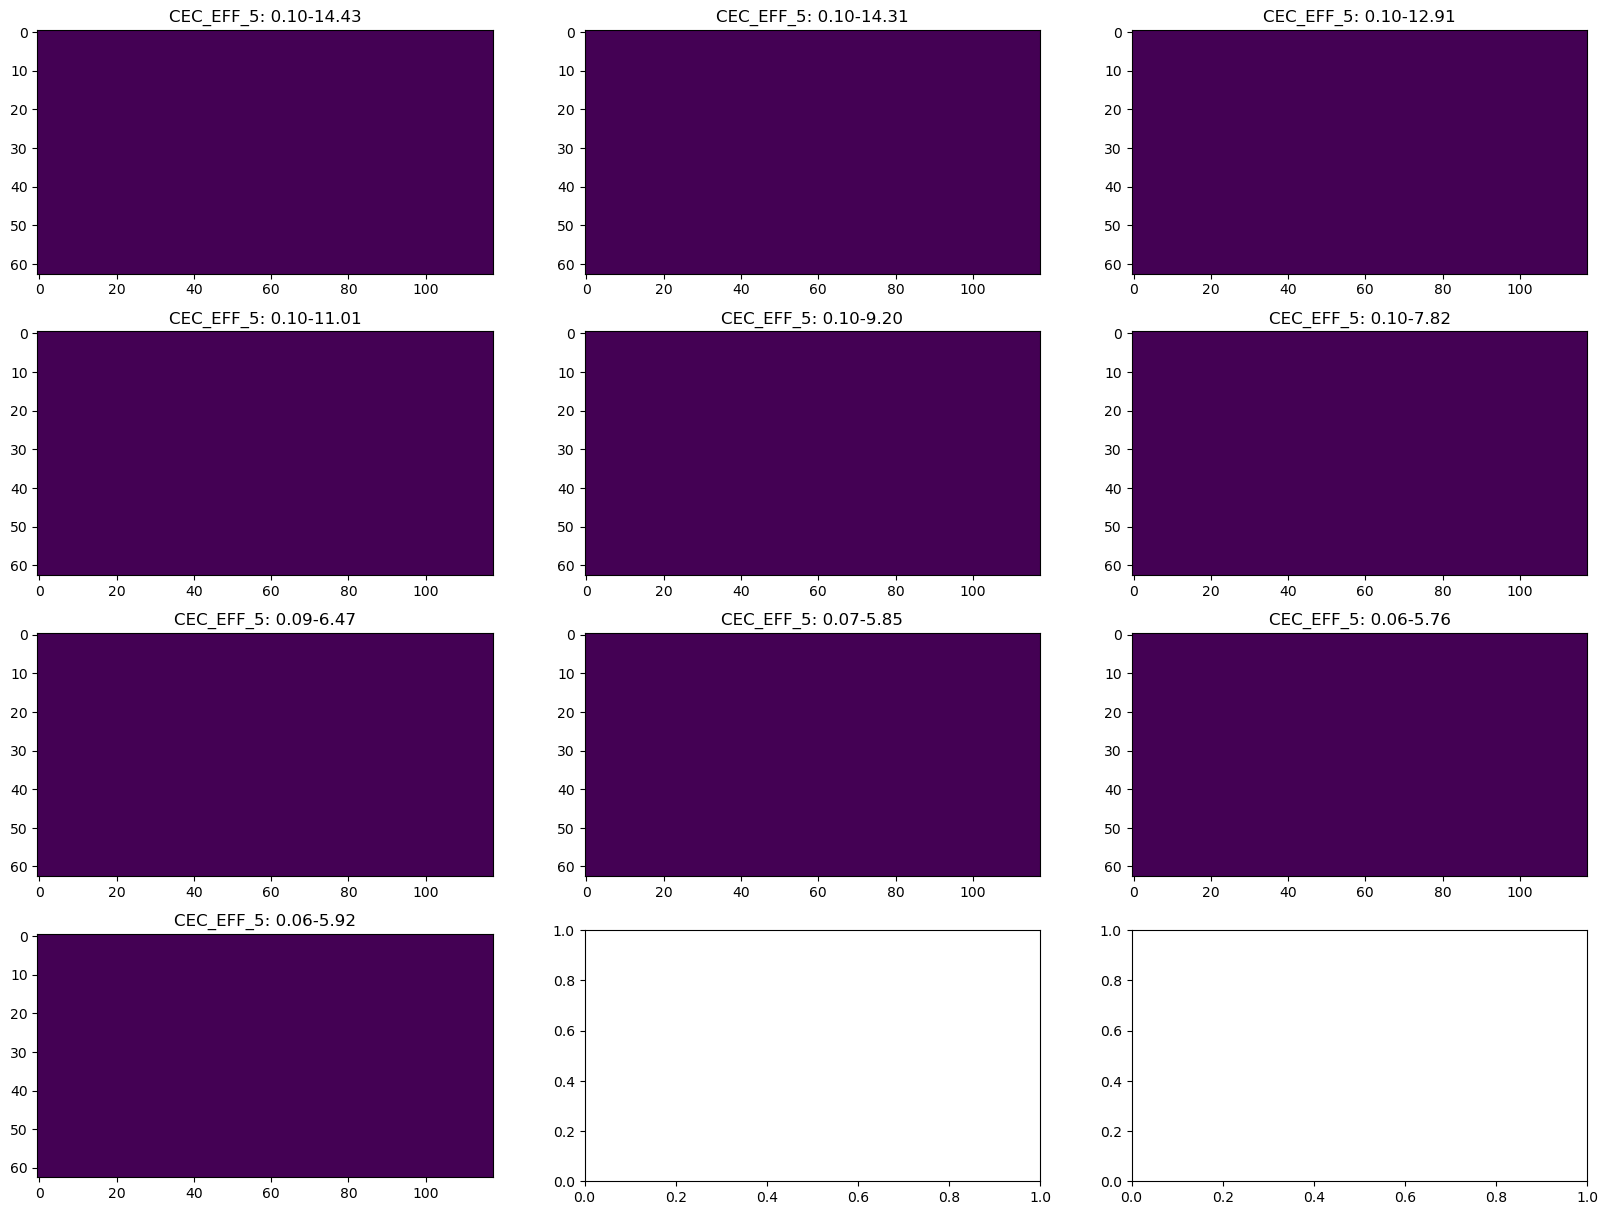

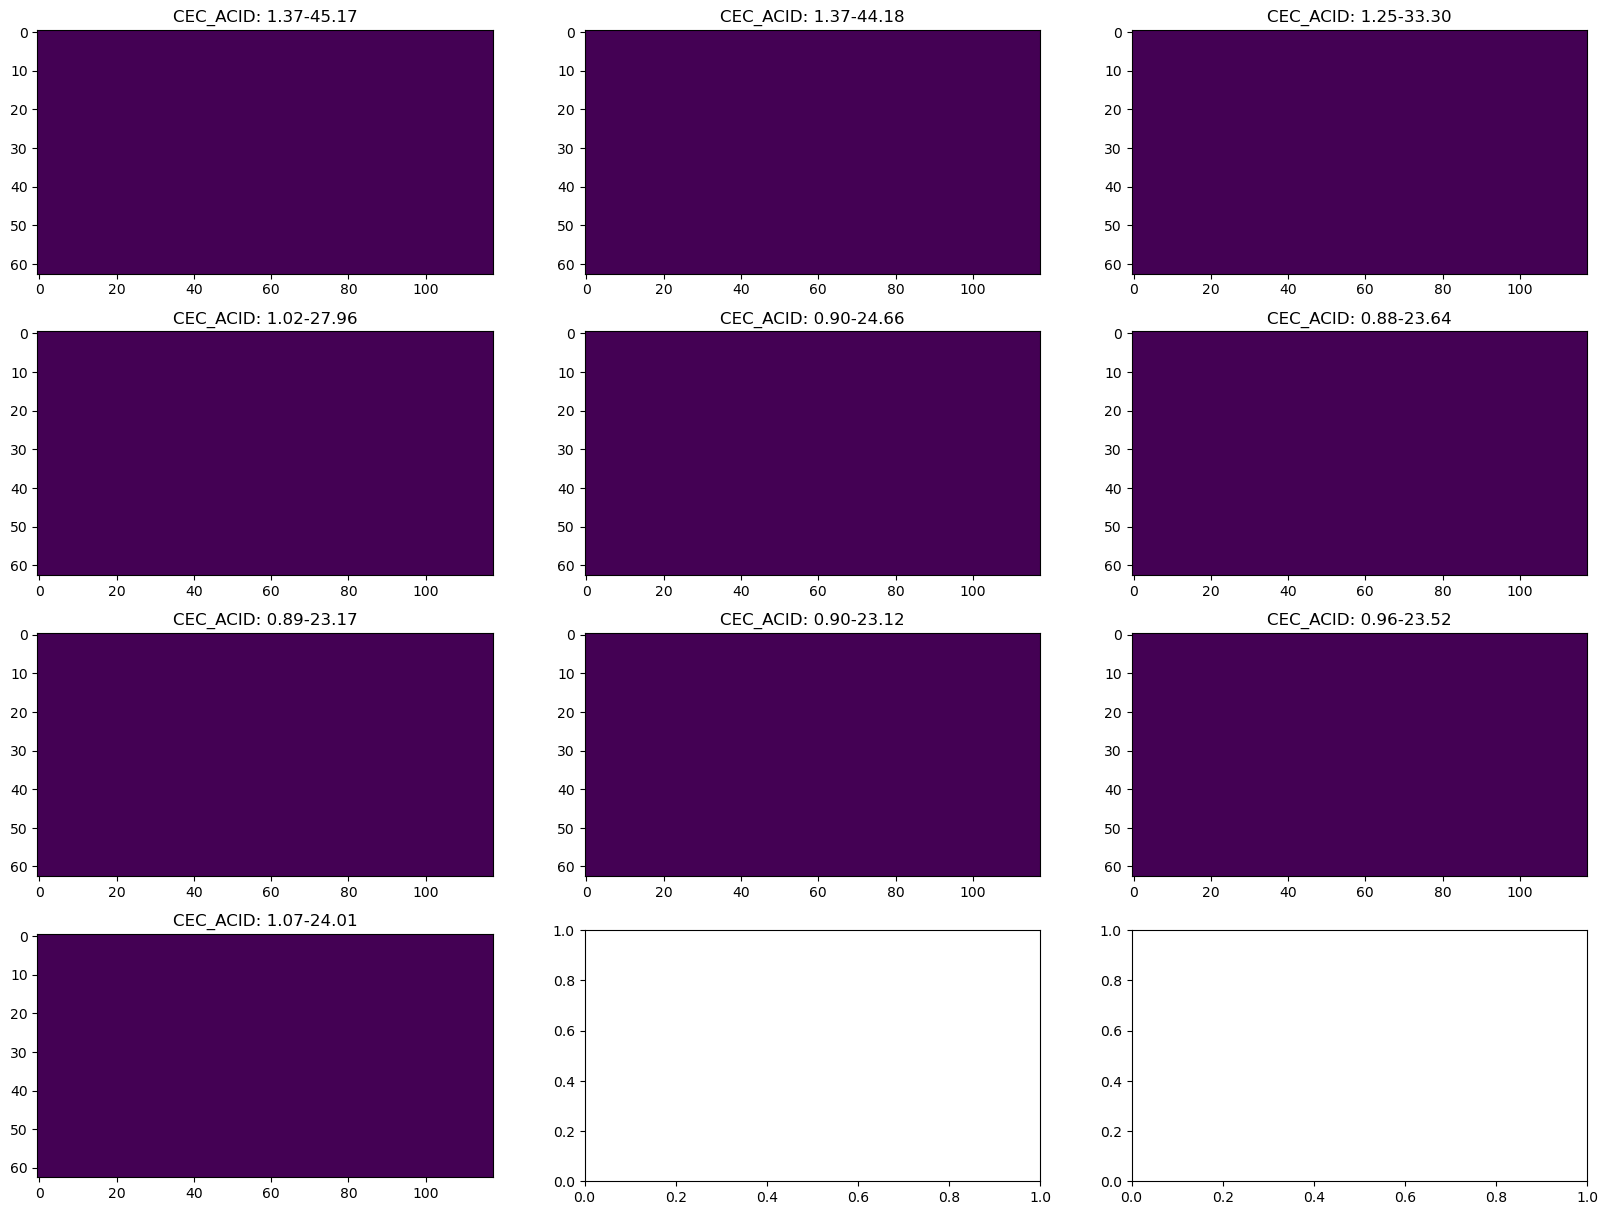

In [30]:
# (4) CEC individuals
for var in ['CEC_EFF_1', 'CEC_EFF_2', 'CEC_EFF_3', 'CEC_EFF_4', 'CEC_EFF_5', 'CEC_ACID']:
    fig, axes = plt.subplots(4, 3, figsize = (20, 15))
    for i in range(10):
        ax = axes.flat[i]
        data = hr[var][i,::-1,:].values
        mask_temp = mask[::-1, :] & ~(data >= 0)
        ax.imshow(mask_temp)
        ax.set_title(
            f'{var}: {np.nanmin(data):.2f}-{np.nanmax(data):.2f}'
        )

In [ ]:
hr.close()

In [ ]:
hr_domain.close()